In [1]:
import numpy as np
import matplotlib.pyplot as plt
from epcsaftpy import component, pcsaft
from epcsaftpy.entropy_scaling import viscosity_pure

In [2]:
R134a = component('R134a', ms = 2.154, sigma = 3.527, eps=  157.227, 
                   mupol = 2.058, xpol = 0.50, Mw = 102.031, viscosity_parameters = [-1.0273633, -1.75196, -0.17433, -0.02626])
eos = pcsaft(R134a)

In [3]:
from pandas import read_excel

Dexp_sat = read_excel('data_exp/R134a.xlsx', 'sat')   
Ts   = np.array(Dexp_sat.iloc[:,0])          # K
Ps   = np.array(Dexp_sat.iloc[:,1])*10       # bar
rhoLs = np.array(Dexp_sat.iloc[:,2])*1e-3    # g cm-3
viscLs= np.array(Dexp_sat.iloc[:,3])         # mPa s
rhoVs = np.array(Dexp_sat.iloc[:,4])*1e-3    # g cm-3
viscVs= np.array(Dexp_sat.iloc[:,5])         # mPa s

Dexp_liquid = read_excel('data_exp/R134a.xlsx', 'liquid')
Th   = np.array(Dexp_liquid.iloc[:,0])      # K
Ph   = np.array(Dexp_liquid.iloc[:,1])*10   # bar
rhoh = np.array(Dexp_liquid.iloc[:,2])*1e-3 # g cm-3
visch= np.array(Dexp_liquid.iloc[:,3])      # mPa s


In [5]:
# VLE calculation
T0 = 120.
Tf = eos.Tc
n = 200                                                # Number of points
Tsat_cal = np.linspace(T0, Tf, n)                      # Temperature vector
Psat_cal = np.zeros_like(Tsat_cal)                     # Vector to save the information
rhosL_cal  = np.zeros_like(Tsat_cal)
rhosV_cal  = np.zeros_like(Tsat_cal)
viscsL_cal  = np.zeros_like(Tsat_cal)
viscsV_cal  = np.zeros_like(Tsat_cal)

for i in range(n - 1):                   
    Psat_cal[i], vl, vv  = eos.psat(Tsat_cal[i])         # Solving and saving the VLE
    rhosL_cal[i] = eos.Mw/vl
    rhosV_cal[i] = eos.Mw/vv
    viscsL_cal[i] = viscosity_pure(1/vl, Tsat_cal[i], eos)
    viscsV_cal[i] = viscosity_pure(1/vv, Tsat_cal[i], eos)

Psat_cal[-1] = eos.Pc   
rhosL_cal[-1] = eos.Mw * eos.rhoc  
rhosV_cal[-1] = eos.Mw * eos.rhoc   
viscsL_cal[-1] = viscosity_pure(eos.rhoc, eos.Tc, eos)
viscsV_cal[-1] = viscosity_pure(eos.rhoc, eos.Tc, eos)

rhosL_cal *= 1e-6
rhosV_cal *= 1e-6
Psat_cal*= 1e-5   # Pa -> bar


# Isothermal calculation
Tset = list(set(Th.tolist()))                      # Identify the different temperature
nT = len(Tset)
Pf = 1e3 * 1e5
n = 100                                            # Number of points
Ph_cal  = np.zeros([n, nT])                        # Vector to save the information
rhoh_cal  = np.zeros([n, nT])                      # Vector to save the information
visch_cal  = np.zeros([n, nT])                     # Vector to save the information
for i in range(nT): 
    P0, vl, vv  = eos.psat(Tset[i])
    Pvec = np.linspace(P0, Pf, n)
    Ph_cal[:, i] = Pvec
    for j in range(n):
        rhocal = eos.density(Tset[i], Pvec[j], "L") # Solving the density
        rhoh_cal[j, i] = rhocal * eos.Mw
        visch_cal[j, i] = viscosity_pure(rhocal, Tset[i], eos)
rhoh_cal *= 1e-6
Ph_cal   *= 1e-5 # Pa -> bar

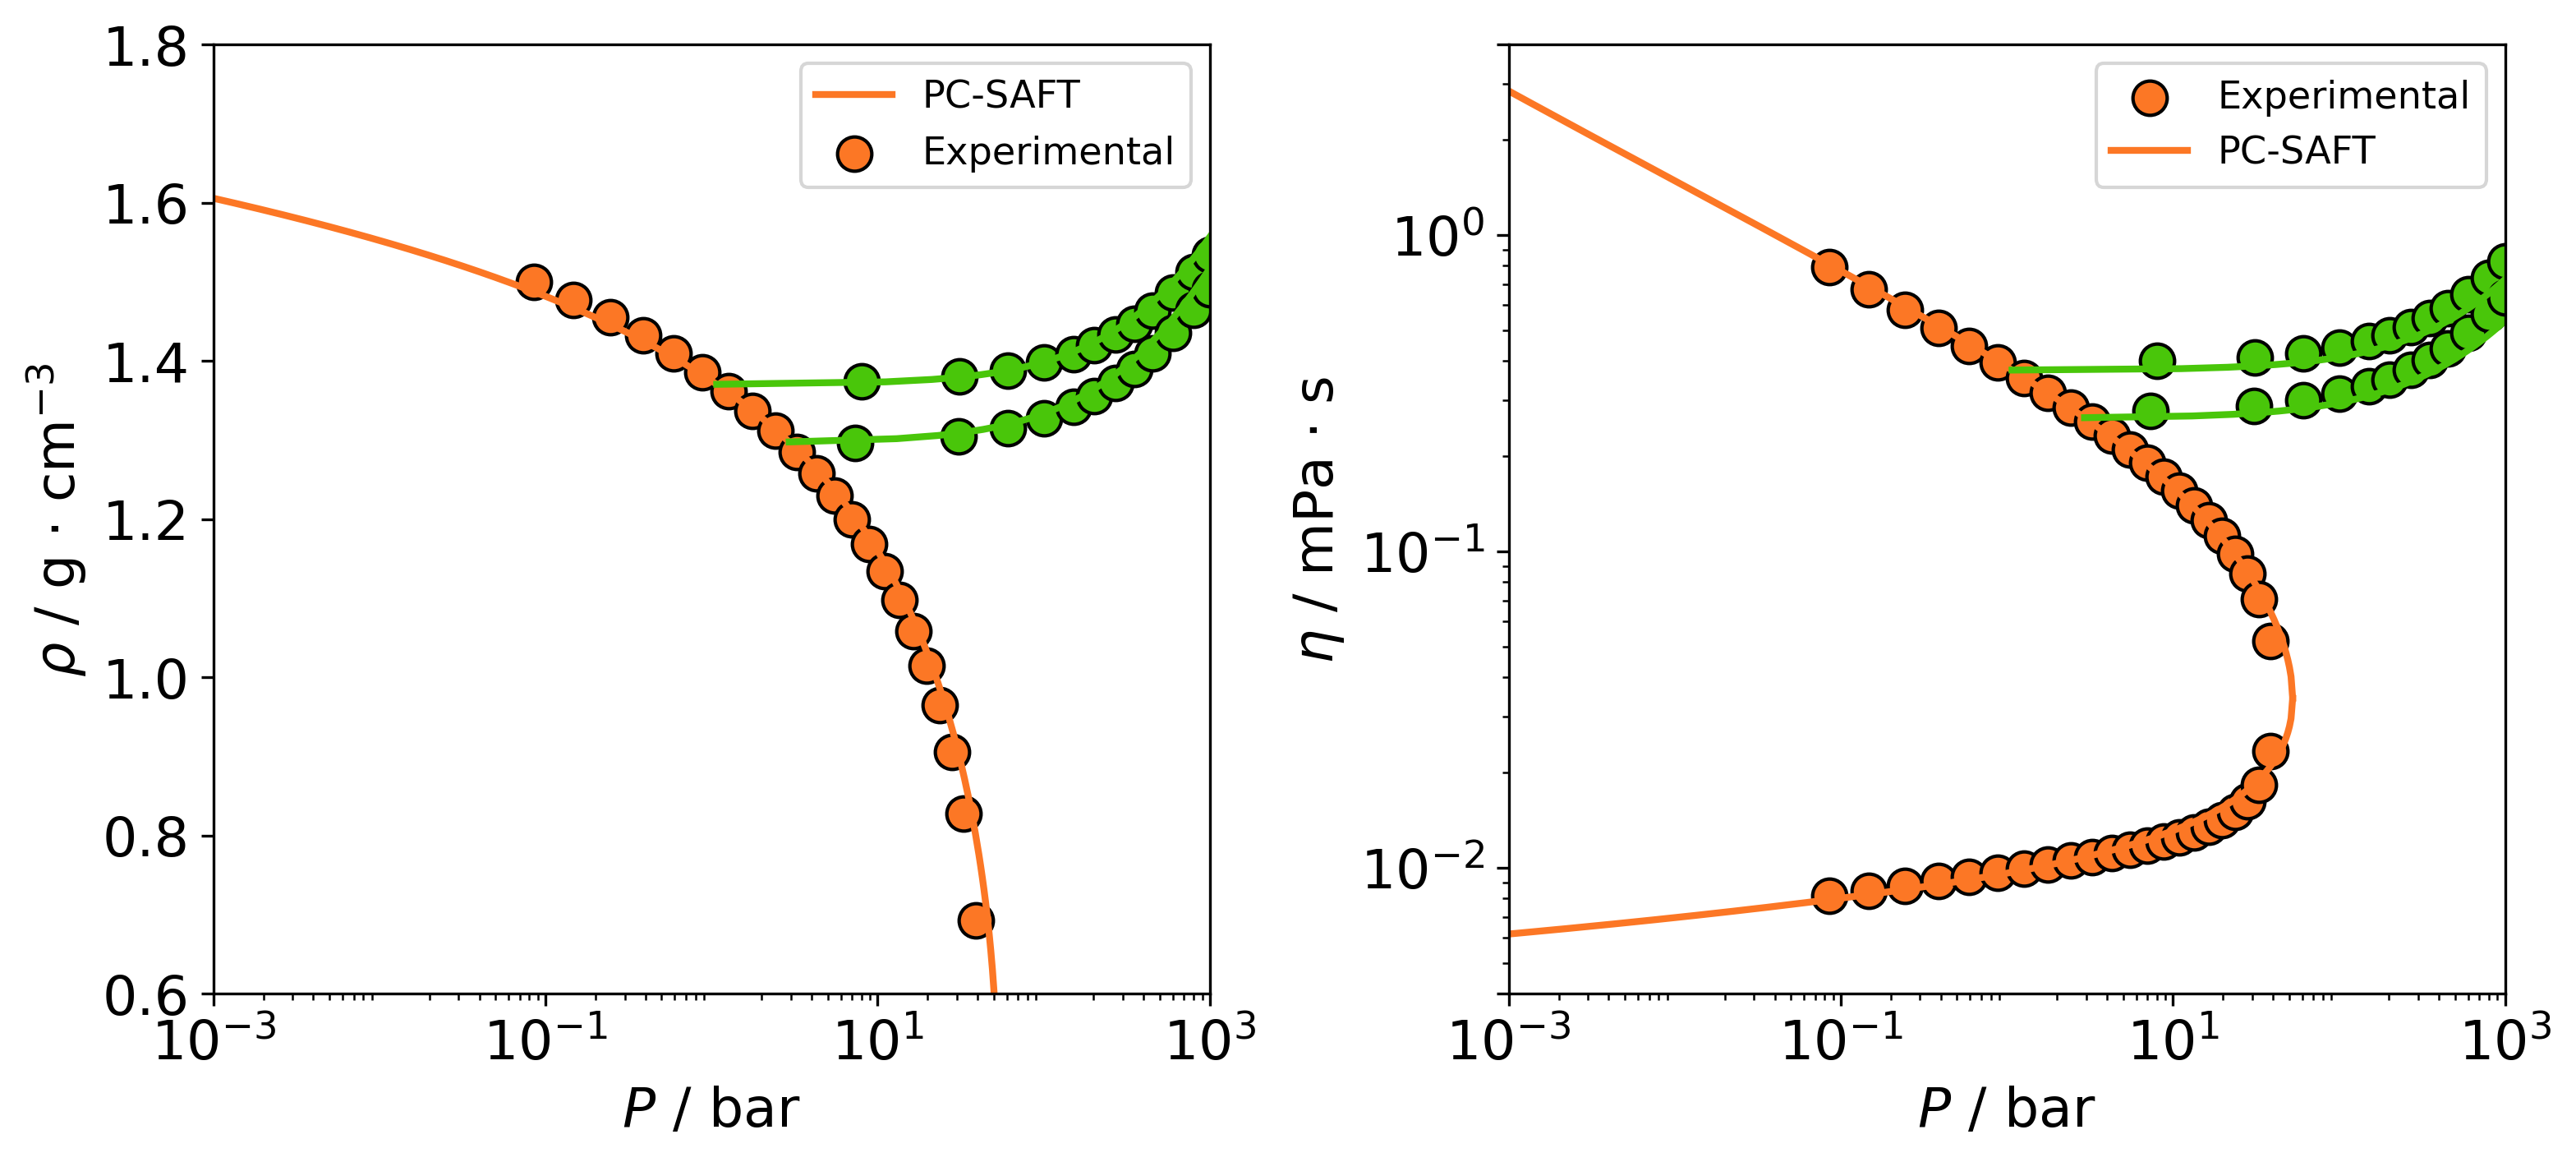

In [6]:
font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)


colorVLE = "#FC7725"
color1 = "#49C60A"

fig, axs = plt.subplots(1,2, figsize=(12, 5), dpi = 300)
fig.subplots_adjust(hspace=0.5, wspace=0.3)


ax = axs[0]

ax.plot(Psat_cal, rhosL_cal, color = colorVLE , 
        linewidth = 2.0, label = "PC-SAFT")
ax.plot(Psat_cal, rhosV_cal, color = colorVLE , 
        linewidth = 2.0)
ax.scatter(Ps, rhoLs, s = 100, c = colorVLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "Experimental")
ax.scatter(Ps, rhoVs, s = 100, c = colorVLE, marker="o", 
            linewidth=1.0, edgecolor='k')

ax.plot(Ph_cal, rhoh_cal, color = color1 , 
        linewidth = 2.0)
ax.scatter(Ph, rhoh, s = 100, c = color1, marker="o", 
            linewidth=1.0, edgecolor='k')

ax.set_xlabel('$P$ / bar')
ax.set_ylabel(r'$\rho$ / g $\cdot$ cm$^{-3}$')
ax.axis([1e-3, 1e3, 0.6, 1.8])

ax.set_xscale('log')
start, end = ax.get_ylim()
ax.xaxis.set_ticks(np.array([1e-3, 1e-1, 1e1, 1e3]))

ax.legend(fontsize = "x-small")

ax = axs[1]
ax.scatter(Ps, viscLs, s = 100, c = colorVLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "Experimental")
ax.scatter(Ps, viscVs, s = 100, c = colorVLE, marker="o", 
            linewidth=1.0, edgecolor='k')
ax.plot(Psat_cal, viscsL_cal, color = colorVLE , 
        linewidth = 2.0, label = "PC-SAFT")
ax.plot(Psat_cal, viscsV_cal, color = colorVLE , 
        linewidth = 2.0)
ax.scatter(Ph, visch, s = 100, c = color1, marker="o", 
            linewidth=1.0, edgecolor='k')
ax.plot(Ph_cal, visch_cal, color = color1 , 
        linewidth = 2.0)

ax.axis([1e-3, 1e3, 4e-3, 4])
ax.set_xlabel('$P$ / bar')
ax.set_ylabel(r'$\eta$ / mPa $\cdot$ s')
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_ticks(np.array([1e-3, 1e-1, 1e1, 1e3]))
ax.yaxis.set_ticks(np.array([0.004, 1e-2, 1e-1, 1, 4]))


ax.legend(fontsize = "x-small")

plt.show()